In [123]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

sns.set(font_scale=1.2)
sns.set_style("white")

In [124]:
# function for processing and simplifying the dataset
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys of the mapping dict.
    It renames the columns to the values of the mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        dff.rename(columns={k: v}, inplace=True)
    return dff

def replaceSize(df):
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "big")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "big")
    return df

In [125]:
# Load data from path
web1 = pd.read_csv("vnf_data/csv_experiments_WEB1.csv")
web2 = pd.read_csv("vnf_data/csv_experiments_WEB2.csv")
web3 = pd.read_csv("vnf_data/csv_experiments_WEB3.csv")

# do processing, renaming and selection
web1["vnf"] = "nginx"
web2["vnf"] = "haproxy"
web3["vnf"] = "squid"

mapping = {
    "param__func__mp.input__cmd_start": "size",
    "metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "Max. throughput [kB/s]",
}

mapping01 = mapping.copy()
mapping01["param__func__de.upb.lb-nginx.0.1__cpu_bw"] = "CPU"

mapping02 = mapping.copy()
mapping02["param__func__de.upb.lb-haproxy.0.1__cpu_bw"] = "CPU"

mapping03 = mapping.copy()
mapping03["param__func__de.upb.px-squid.0.1__cpu_bw"] = "CPU"

web1 = select_and_rename(web1, mapping01)
web2 = select_and_rename(web2, mapping02)
web3 = select_and_rename(web3, mapping03)

web1 = replaceSize(web1)
web2 = replaceSize(web2)
web3 = replaceSize(web3)

c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [126]:
# select sub-datasets with small and large flows
web1_small = web1.loc[web1["size"] == "small"]
web1_big = web1.loc[web1["size"] == "big"]

web2_small = web2.loc[web2["size"] == "small"]
web2_big = web2.loc[web2["size"] == "big"]

web3_small = web3.loc[web3["size"] == "small"]
web3_big = web3.loc[web3["size"] == "big"]

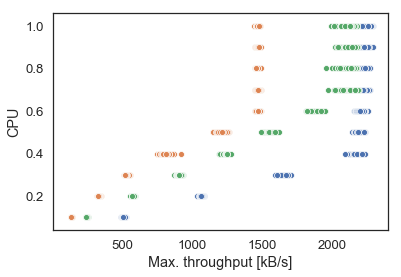

In [127]:
# plot cpu and Max. throughput [kB/s]
sns.scatterplot(web1_small['Max. throughput [kB/s]'], web1_small['CPU'])
# sns.scatterplot(web1_big['Max. throughput [kB/s]'], web1_big['CPU'])
sns.scatterplot(web2_small['Max. throughput [kB/s]'], web2_small['CPU'])
# sns.scatterplot(web2_big['Max. throughput [kB/s]'], web2_big['CPU'])
sns.scatterplot(web3_small['Max. throughput [kB/s]'], web3_small['CPU'])
# sns.scatterplot(web3_big['Max. throughput [kB/s]'], web3_big['CPU'])

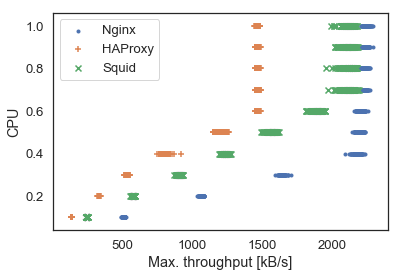

In [128]:
# proper plotting of VNF data for paper
# only use data with small flows
def plot_vnf_data():
    fig, ax = plt.subplots()
    plt.scatter(web1_small['Max. throughput [kB/s]'], web1_small['CPU'], label='Nginx', marker='.')
    plt.scatter(web2_small['Max. throughput [kB/s]'], web2_small['CPU'], label='HAProxy', marker='+')
    plt.scatter(web3_small['Max. throughput [kB/s]'], web3_small['CPU'], label='Squid', marker='x')

    # labels
    ax.set_xlabel('Max. throughput [kB/s]')
    ax.set_ylabel('CPU')
    plt.legend()
    
    fig.savefig(f'plots/web_vnf_data.pdf', bbox_inches='tight')
    
plot_vnf_data()

In [129]:
def display_scores(scores):
    print(f"Mean: {scores.mean()}")
    print(f"Std: {scores.std()}")
    
def do_cv(model, X_train, y_train, k=5):
    # train score
    print("Train score:")
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    display_scores(rmse)
    
    # CV score
    print("CV score:")
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=k)
    rmse = np.sqrt(-scores)
    display_scores(rmse)
    
    return rmse    
    
def check_model(X_train, y_train, model):
    """Do test, train split; k-fold CV; and visualize"""
    name = type(model).__name__
    print(f"\n{name}")
    
    rmse = do_cv(model, X_train, y_train)
#     predict_plot_all(model, X, y)

    return rmse

In [130]:
data = web1_small
vnf_name = 'web1_small'

# prepare train and test set
X = data[['Max. throughput [kB/s]']]
y = data['CPU']
X = X.fillna(X.median())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rmse_lin = check_model(X_train, y_train, LinearRegression())
rmse_ridge = check_model(X_train, y_train, Ridge())
rmse_svr = check_model(X_train, y_train, SVR())
rmse_forest = check_model(X_train, y_train, RandomForestRegressor())
rmse_boost = check_model(X_train, y_train, GradientBoostingRegressor())
rmse_mlp = check_model(X_train, y_train, MLPRegressor())


LinearRegression
Train score:
Mean: 0.16927137275836965
Std: 0.0
CV score:
Mean: 0.1696628744604315
Std: 0.00449610309571789

Ridge
Train score:
Mean: 0.16927137275836965
Std: 0.0
CV score:
Mean: 0.16966287445738304
Std: 0.004496103143475886

SVR
Train score:
Mean: 0.11516569548741162
Std: 0.0
CV score:
Mean: 0.16338188058433503
Std: 0.006493064949294863

RandomForestRegressor
Train score:
Mean: 0.05835333670632645
Std: 0.0
CV score:
Mean: 0.1335981019698257
Std: 0.00690524223605887

GradientBoostingRegressor
Train score:
Mean: 0.09041385775574448
Std: 0.0
CV score:
Mean: 0.11772074637659355
Std: 0.009151823589298799

MLPRegressor
Train score:
Mean: 0.1826400460291423
Std: 0.0
CV score:
Mean: 0.2025670010101392
Std: 0.03636851270477343


In [131]:
# bar plot comparing the RMSE of the different algorithms
def barplot_rmse(scores, labels, data_name):
    assert len(scores) == len(labels)
    
    # preparation
    rmse_mean = [s.mean() for s in scores]
    rmse_std = [s.std() for s in scores]
    x = np.arange(len(labels))

    # plot
    fig, ax = plt.subplots()
    plt.bar(x, rmse_mean, color='grey', yerr=rmse_std, capsize=5)

    # labels
    ax.set_xlabel('Machine learning models')
    ax.set_ylabel('RMSE')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    fig.savefig(f'plots/{data_name}_rmse.pdf', bbox_inches='tight')

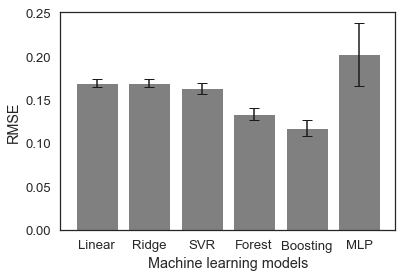

In [132]:
labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP']
scores = [rmse_lin, rmse_ridge, rmse_svr, rmse_forest, rmse_boost, rmse_mlp]

barplot_rmse(scores, labels, vnf_name)

In [133]:
def predict_plot_all(X, y, vnf_name):
    """Given a list of models, fit all to the data, save model, and plot their predictions"""
    models = [LinearRegression(), GradientBoostingRegressor()]
    labels = ['Linear', 'Boosting']
    markers = ['x', '^']
    colors = ['blue', 'red']
    
    fig, ax = plt.subplots()    
    plt.scatter(X, y, label='True', marker='o', color='black')
    for i, model in enumerate(models):
        # train and save model
        name = type(model).__name__
        model.fit(X, y)
        joblib.dump(model, f'ml_models/{vnf_name}/{name}.joblib')
        # predict and plot data
        X_plot = pd.DataFrame({'Max. throughput [kB/s]': np.arange(200, 2500, 50)})
        y_pred = model.predict(X_plot)
        plt.scatter(X_plot, y_pred, label=labels[i], marker=markers[i], color=colors[i])
    plt.xlabel('Max. throughput [kB/s]')
    plt.ylabel('CPU')
    plt.legend()
    fig.savefig(f'plots/{vnf_name}_model_comparison.pdf')

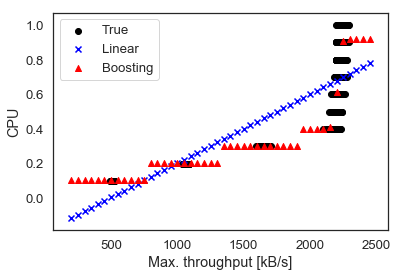

In [134]:
predict_plot_all(X, y, vnf_name)

In [135]:
# TODO: tune hyper params and check difference. probably only do this for the best model or so

# MLP
# param_grid = {
#     'hidden_layer_sizes': [(64,), (128,), (256), (64,64,)],
#     'learning_rate_init': [0.01, 0.001, 0.0001],
#              }
# grid_search = GridSearchCV(MLPRegressor(), param_grid, cv=5, scoring="neg_mean_squared_error")
# grid_search.fit(X_train, y_train)

# # grid_search.best_estimator_
# # np.sqrt(-grid_search.best_score_)

# print(grid_search.best_params_)

# # get CV score of best 
# idx = grid_search.best_index_
# score = grid_search.cv_results_['mean_test_score'][idx]
# std = grid_search.cv_results_['std_test_score'][idx]
# np.sqrt(-score)